In [10]:
import numpy as np
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from utils import plot_2d_visualization, plot_digits_on_points, plot_multiple_2d_visualizations

np.random.seed(0)

# Experiment 1: Reproduce the results of the paper

In [11]:
# prep data

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data / 255.0
y = mnist.target.astype(int)
X = np.array(X)
y = np.array(y)

# select subset of data
indices = np.random.choice(len(X), 6000, replace=False)
X_subset = X[indices]
y_subset = y[indices]

pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_subset)

/Users/jantiegges/.pyenv/versions/3.11.5/envs/a4-comp551/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


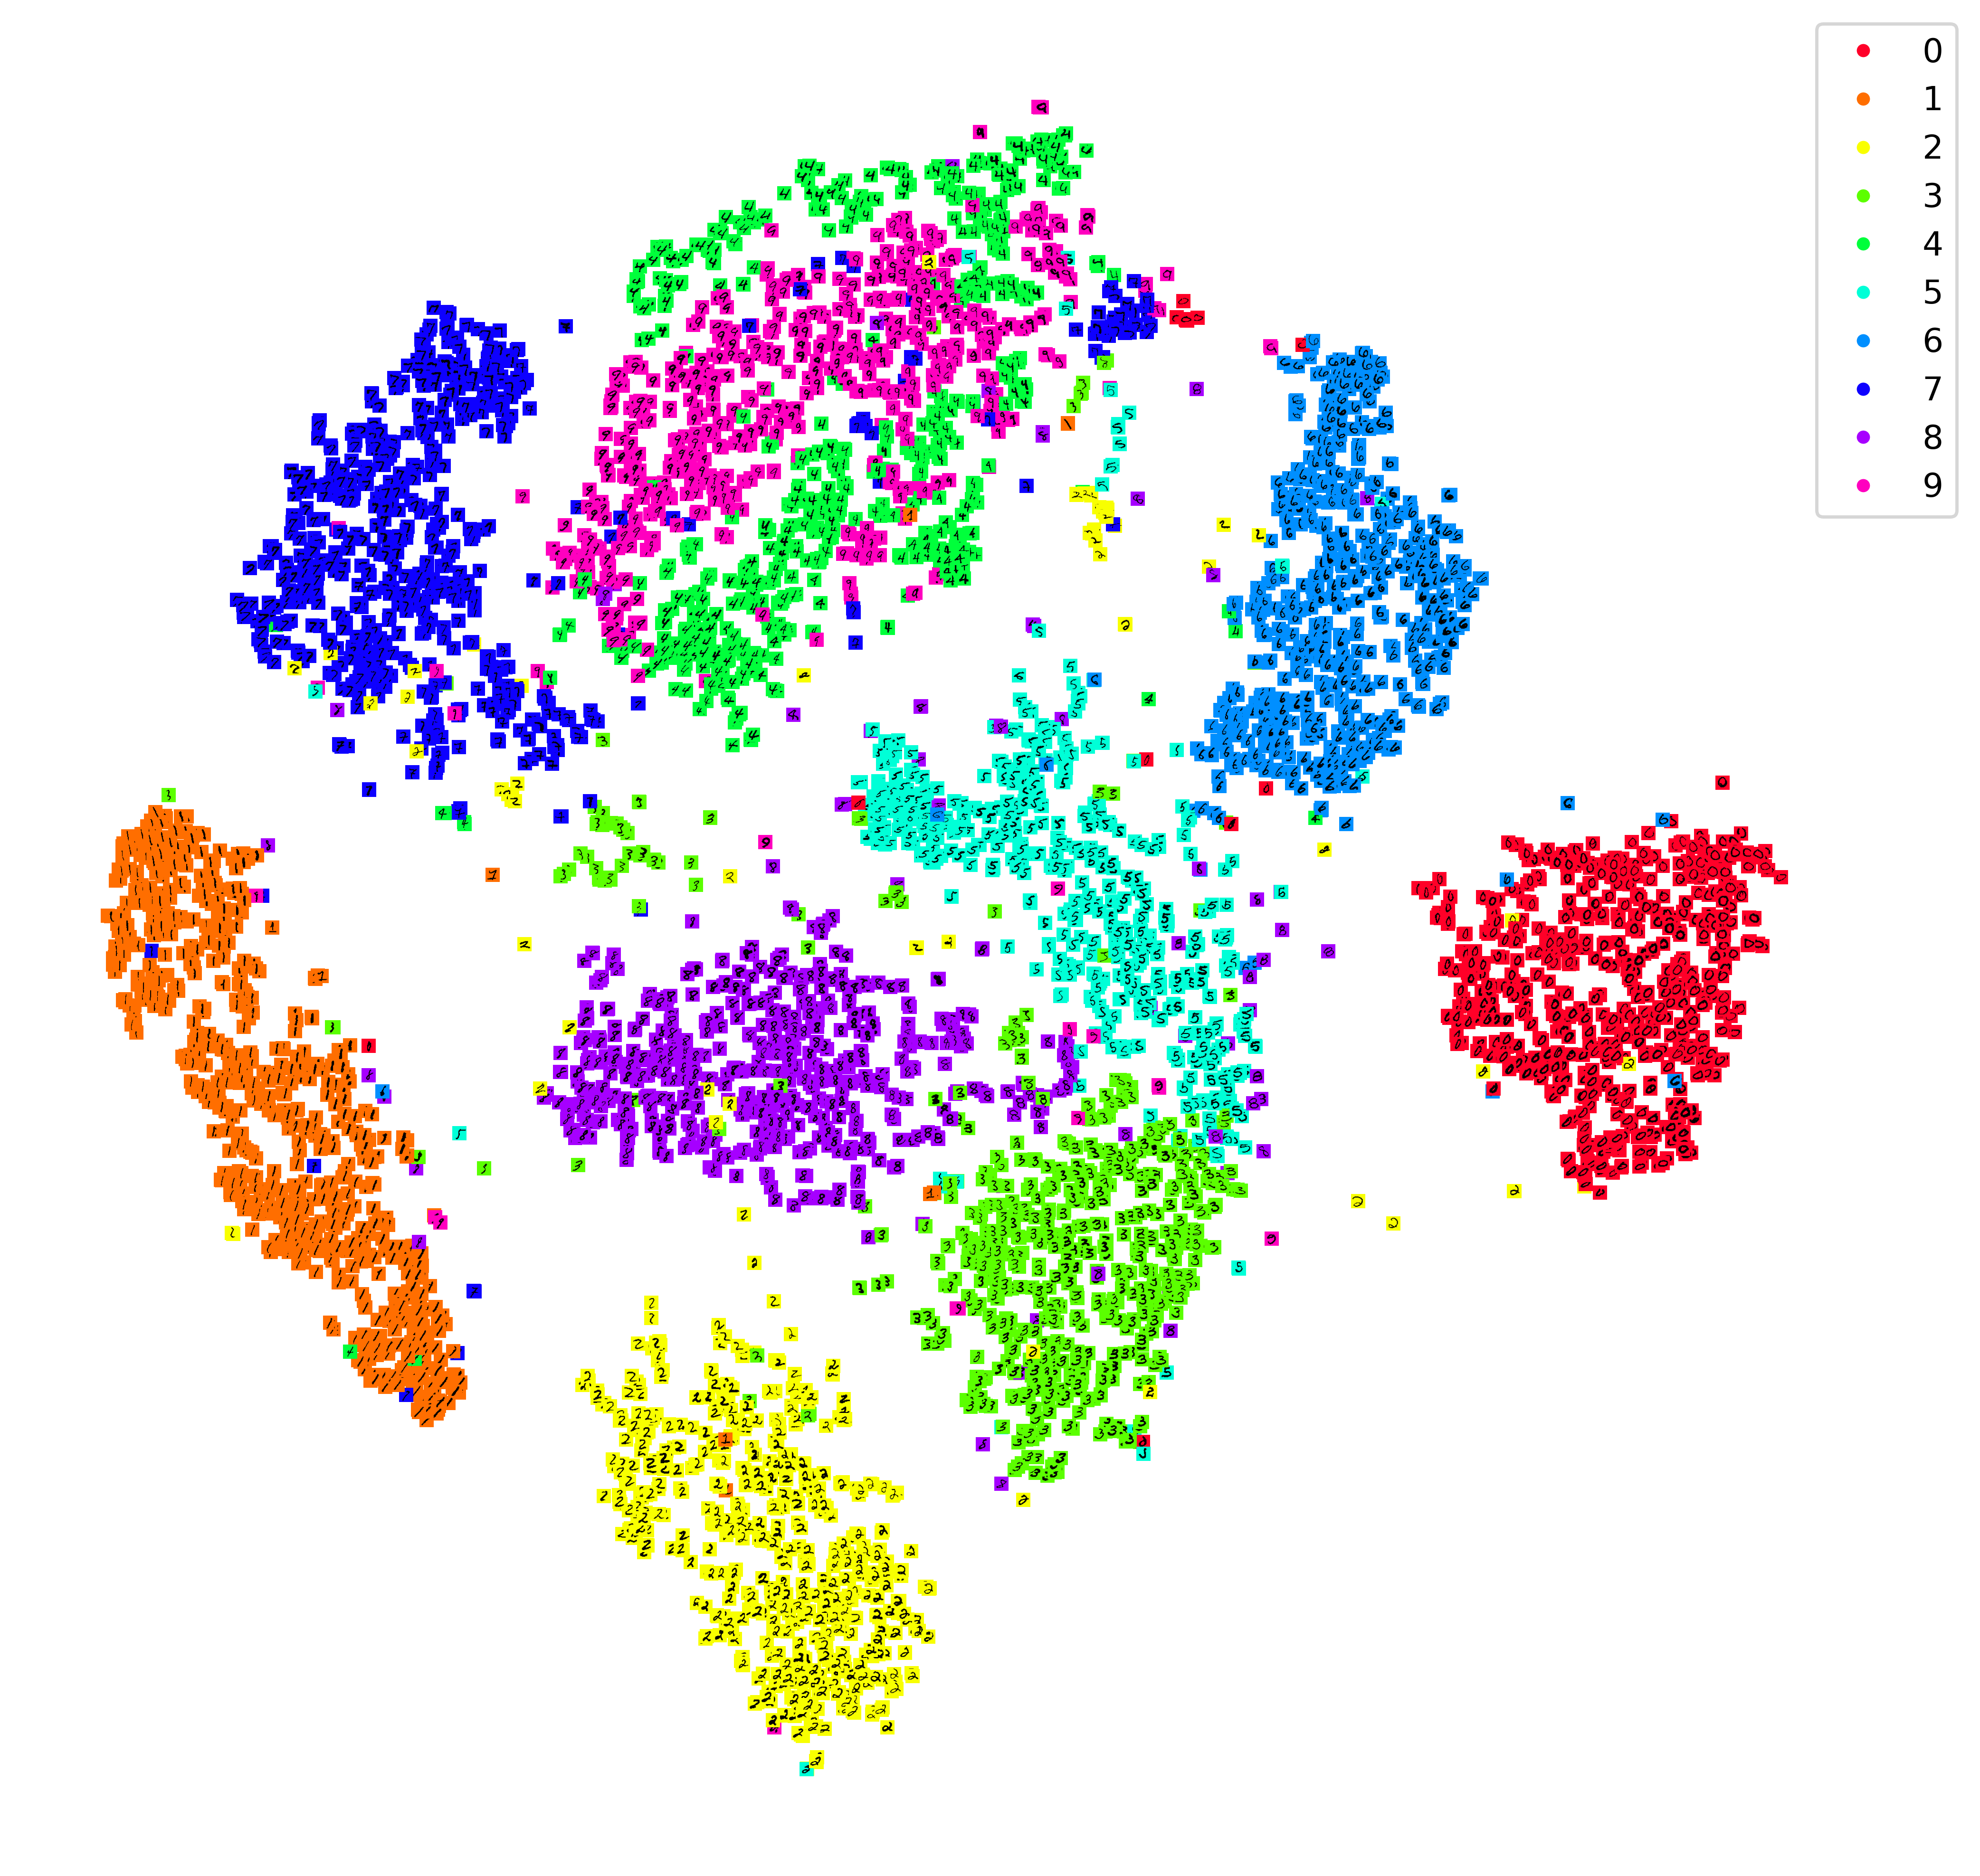

In [12]:
tsne = TSNE(n_components=2, perplexity=40)
X_tsne = tsne.fit_transform(X_pca)

#plot_2d_visualization(X_tsne, y_subset, figsize=(10, 10))
plot_digits_on_points(X_subset, X_tsne, y_subset, figsize=(10, 10), dpi=500)

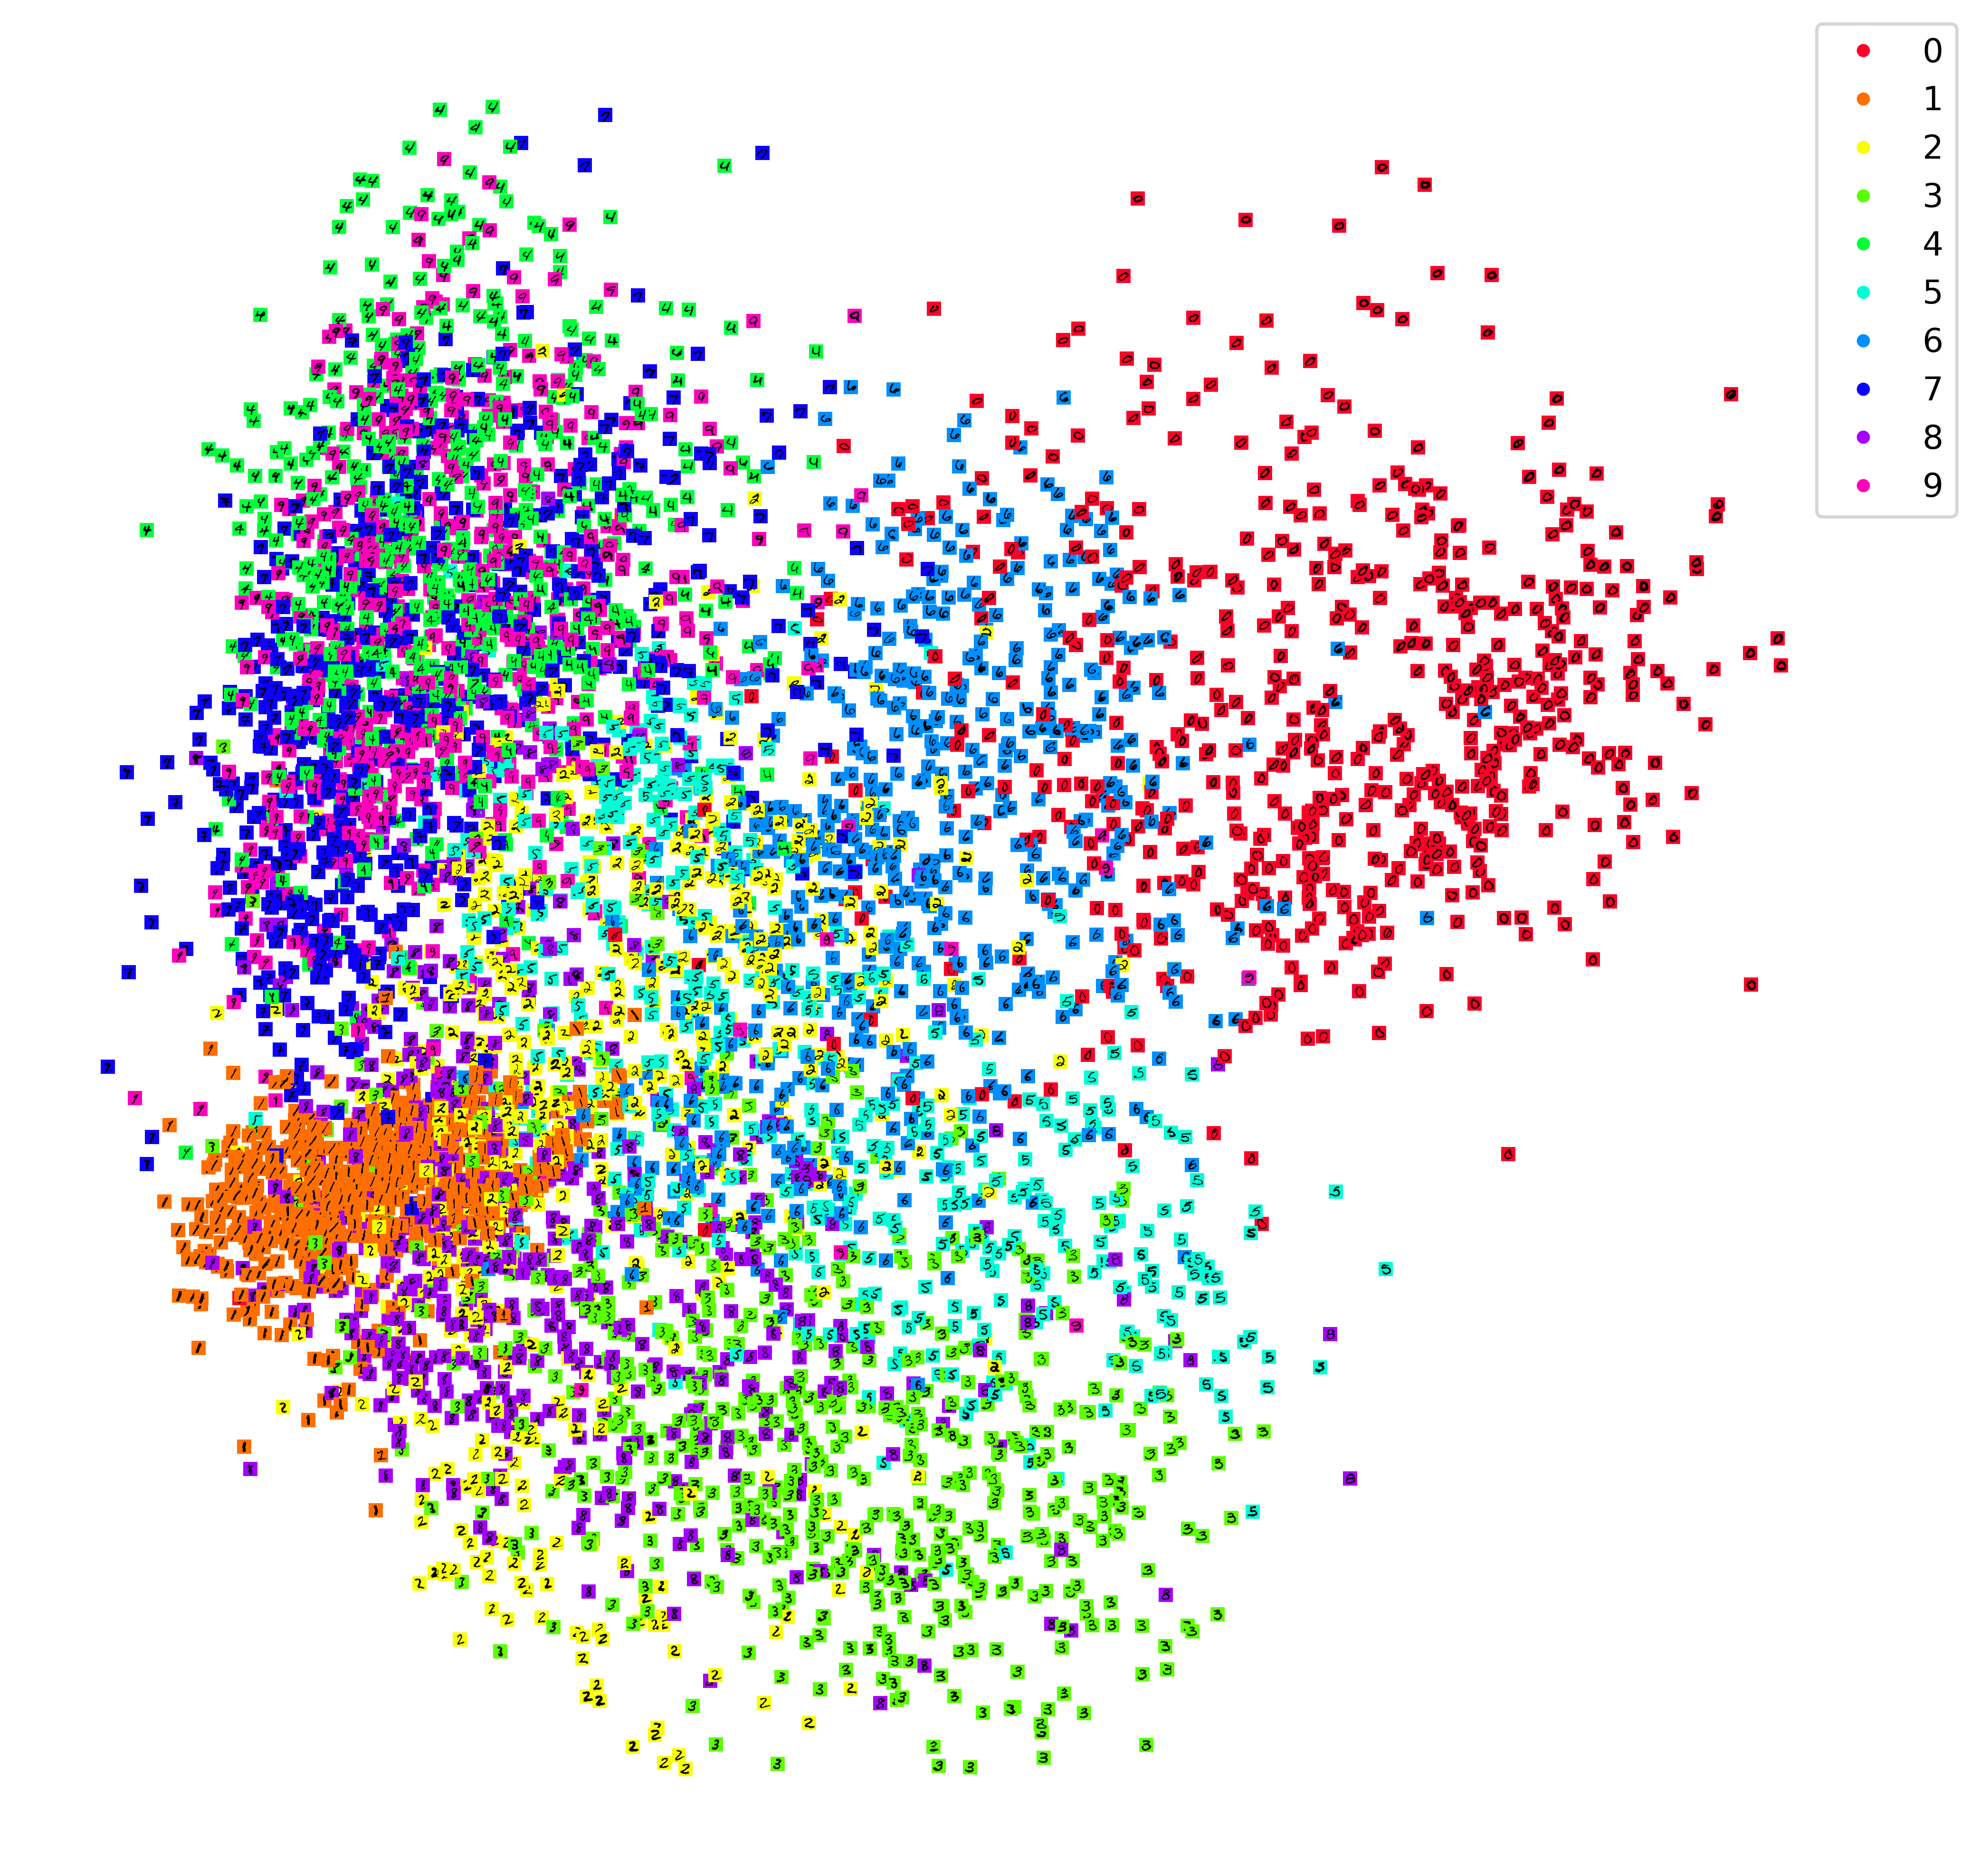

In [13]:
isomap = Isomap(n_components=2, n_neighbors=12)
X_isomap = isomap.fit_transform(X_pca)

#plot_2d_visualization(X_isomap, y_subset, figsize=(10, 10))
plot_digits_on_points(X_subset, X_isomap, y_subset, figsize=(10, 10), dpi=500)

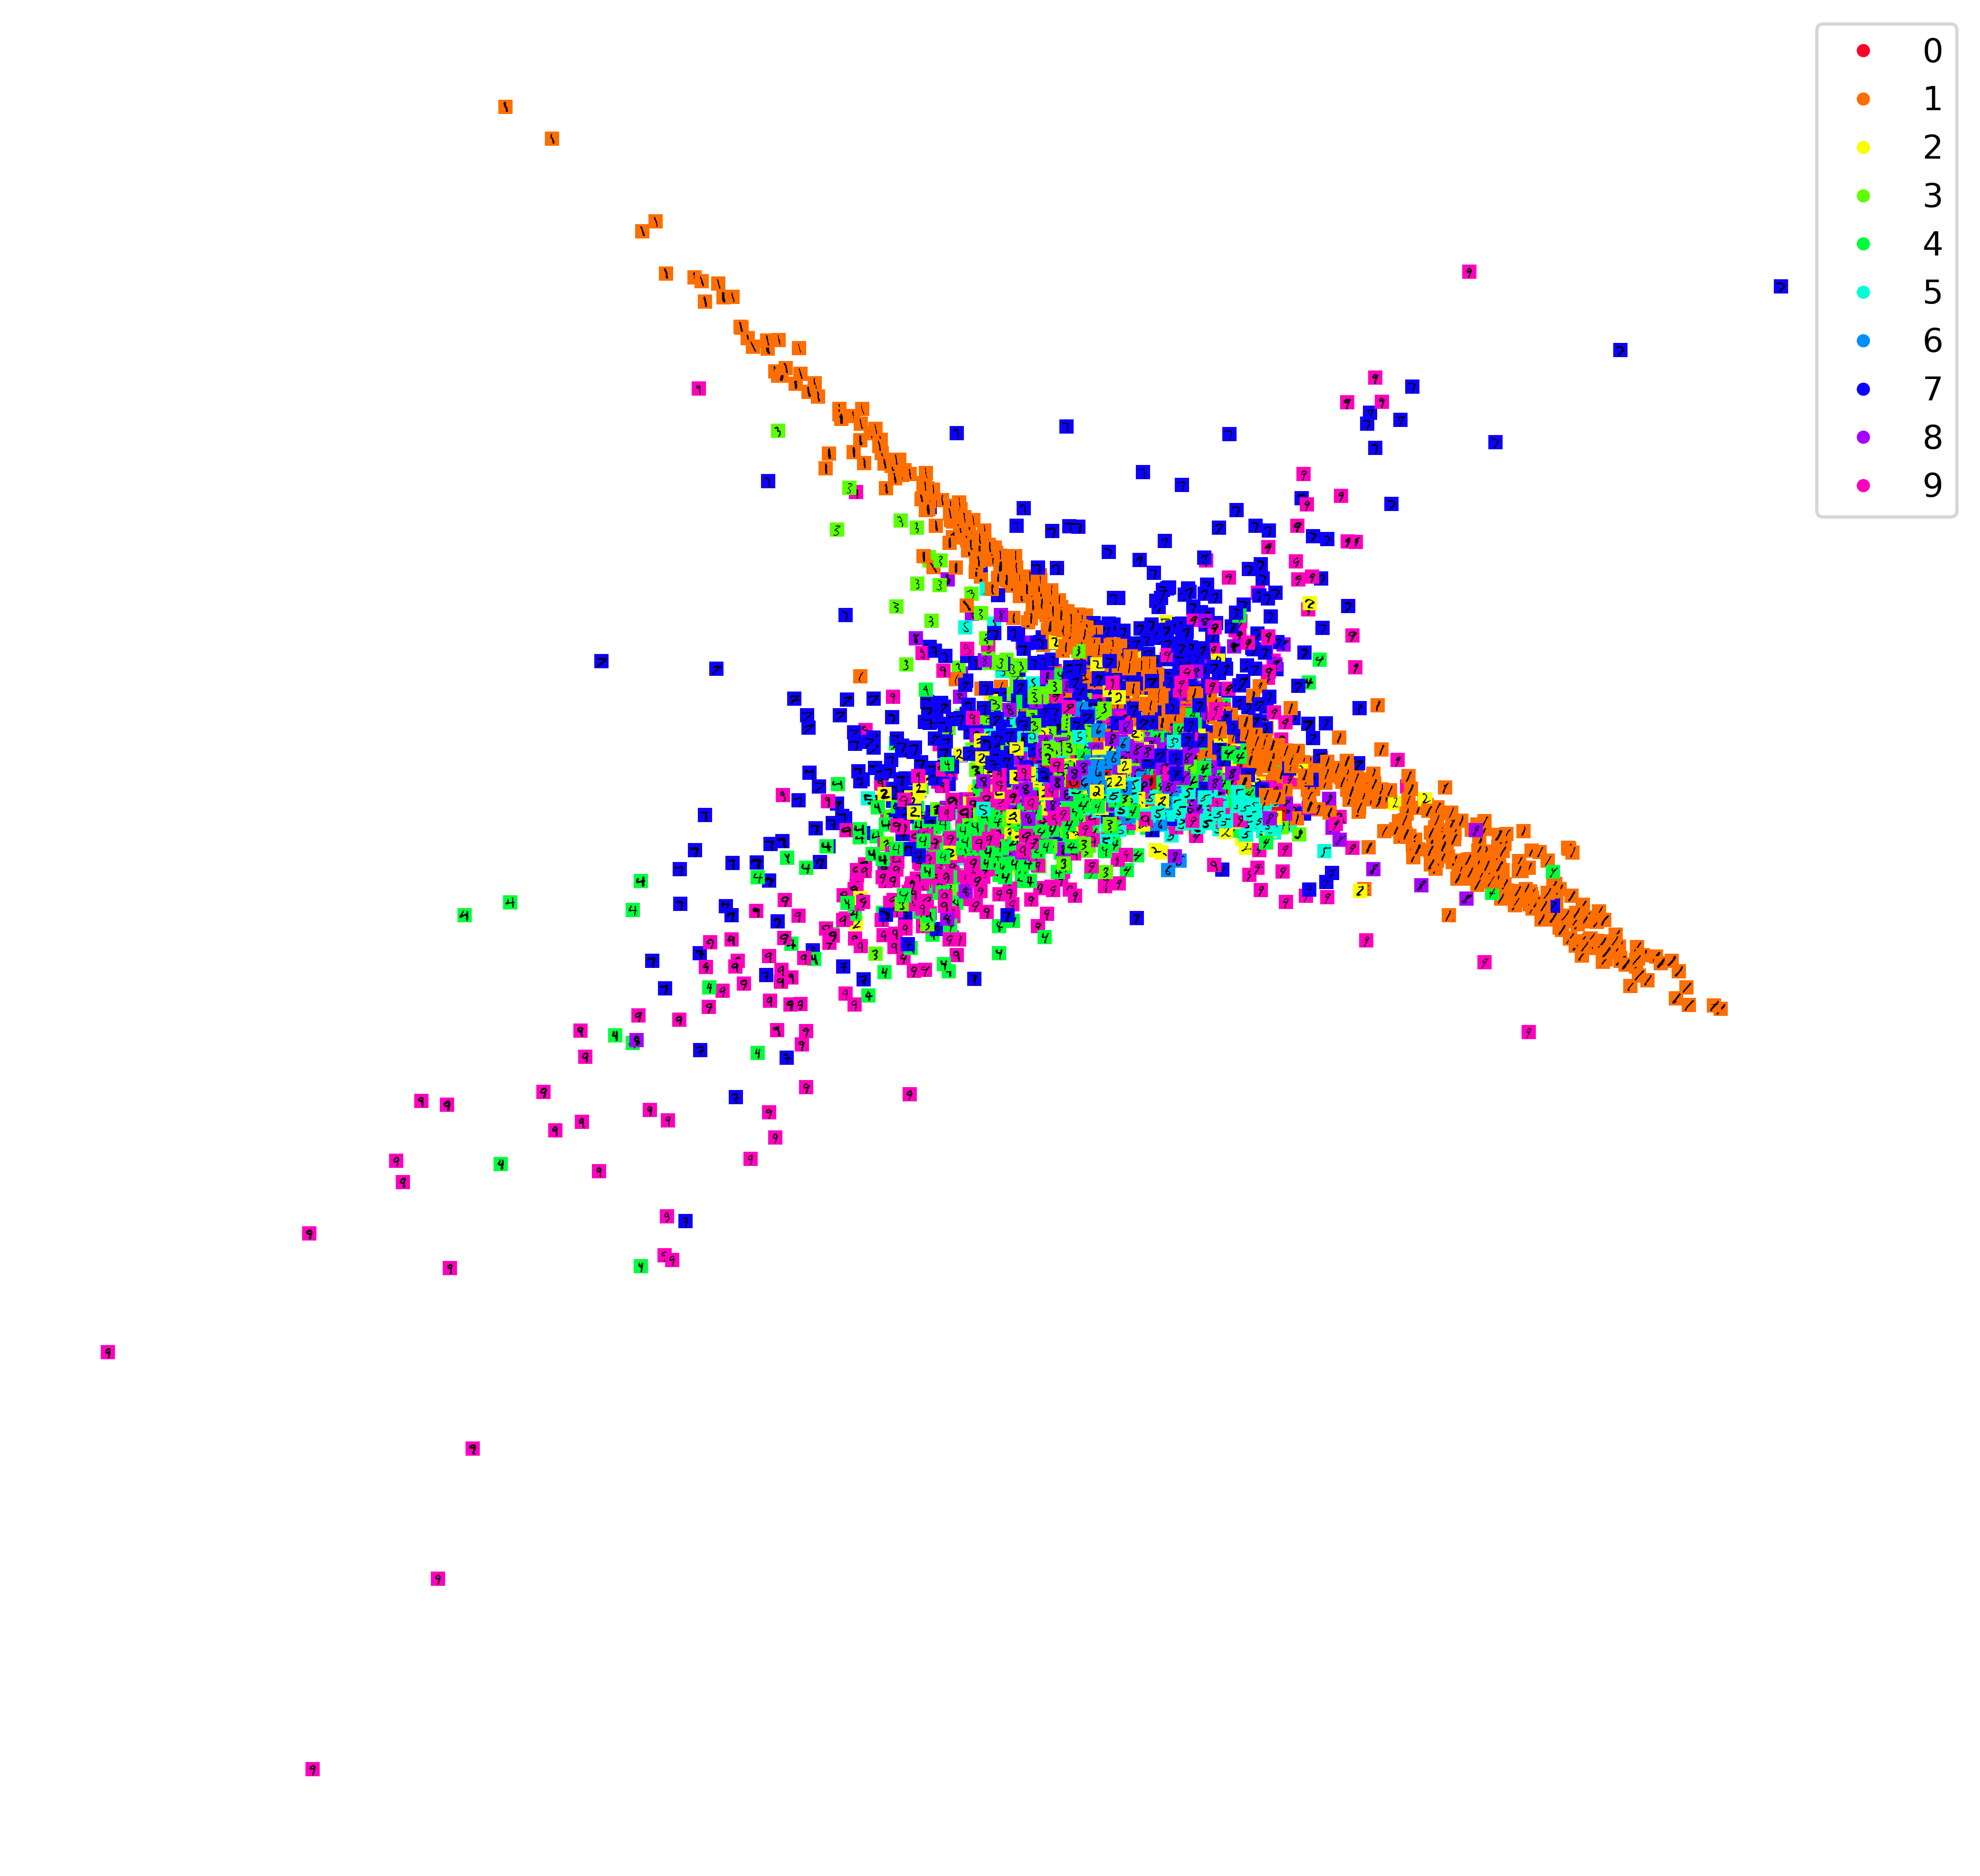

In [14]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=12)
X_lle = lle.fit_transform(X_pca)

#plot_2d_visualization(X_lle, y_subset, figsize=(10, 10))
plot_digits_on_points(X_subset, X_lle, y_subset, figsize=(10, 10), dpi=500)

# Ablation Study 1: Perplexity for t-SNE

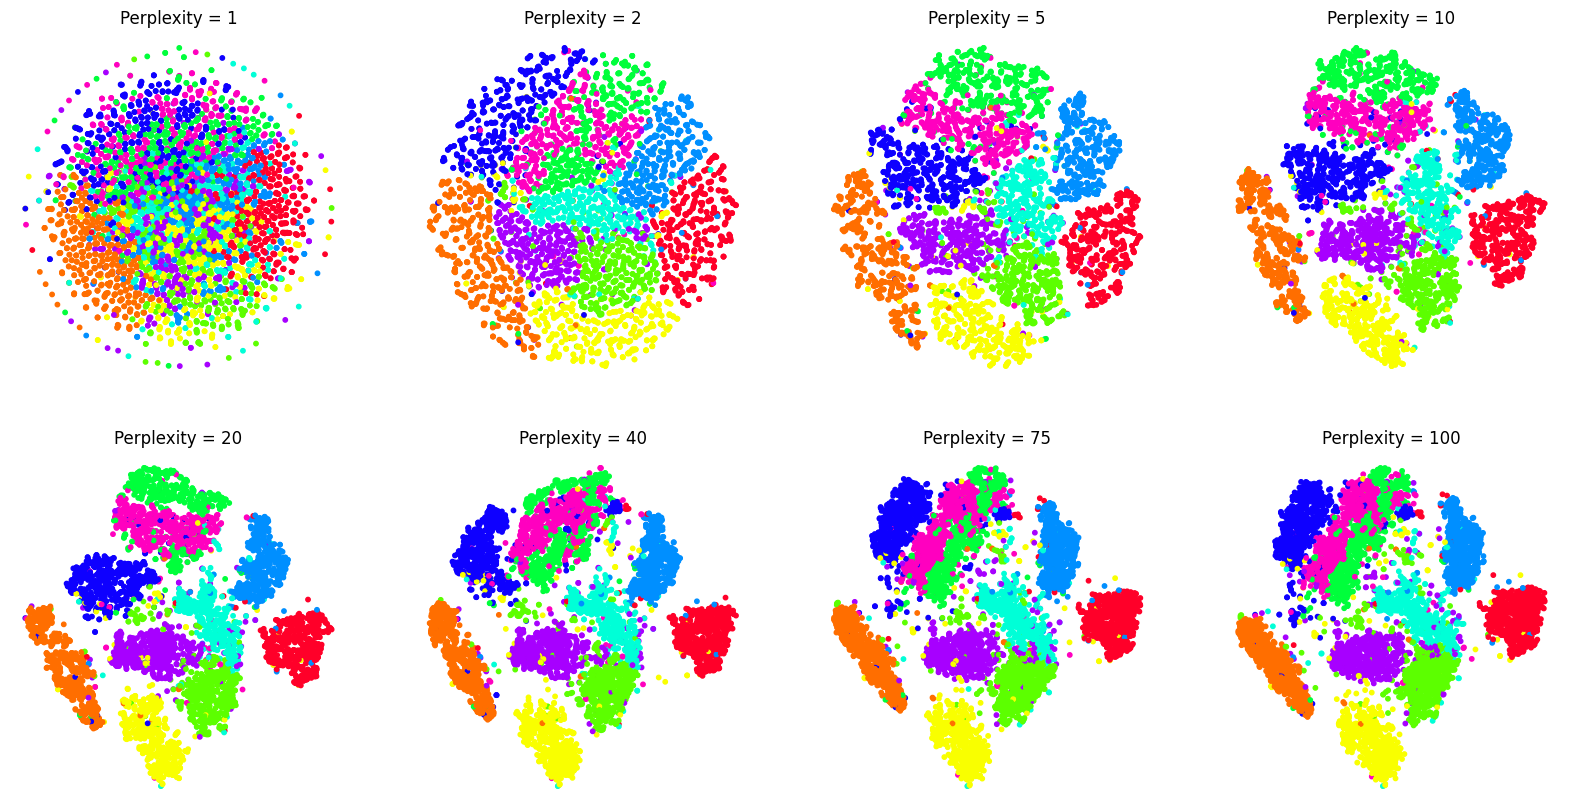

In [15]:
perplexities = [1, 2, 5, 10, 20, 40, 75, 100]

X_tsne_list = []
titles = []

for perplexity in perplexities:
    tsne_p = TSNE(n_components=2, perplexity=perplexity)
    X_tsne_list.append(tsne_p.fit_transform(X_pca))
    titles.append('Perplexity = {}'.format(perplexity))

plot_size = [2, 4]
plot_multiple_2d_visualizations(X_tsne_list, y_subset, titles, plot_size, legend=False)
    

# Ablation Study 2: Performance of t-SNE embeddings for different classifiers

## Logistic Regression

In [16]:
def train_and_evaluate(X_data, y_data, method='original', classifier='logistic', scale_data=False):
    # Scale the data if specified
    if scale_data:
        scaler = StandardScaler()
        X_data = scaler.fit_transform(X_data)
    
    # Select the appropriate classifier
    if classifier == 'logistic':
        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
    elif classifier == 'knn-1':
        clf = KNeighborsClassifier(n_neighbors=1)
    elif classifier == 'knn-3':
        clf = KNeighborsClassifier(n_neighbors=3)
    elif classifier == 'knn-5':
        clf = KNeighborsClassifier(n_neighbors=5)
    elif classifier == 'random_forest':
        clf = RandomForestClassifier(random_state=0)
    else:
        raise ValueError(f"Invalid classifier: {classifier}")
    
    # Define the number of folds for cross-validation
    k_folds = 10
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
    
    # Perform cross-validation
    accuracies = cross_val_score(clf, X_data, y_data, cv=kf, scoring='accuracy')
    
    # Return accuracy and generalization error
    return {'Method': method, 'Classifier': classifier, 'Average Accuracy': accuracies.mean(), 'Average Generalization Error': 1 - accuracies.mean()}

# Example usage and table creation:
results = []

# Iterate over methods, classifiers, and scaling options
for method, X_data in [('t-SNE', X_tsne), ('Isomap', X_isomap), ('LLE', X_lle), ('PCA', X_pca), ('Original', X_subset)]:
    for classifier in ['logistic', 'knn-1', 'knn-3', 'knn-5', 'random_forest']:
        result = train_and_evaluate(X_data, y_subset, method=method, classifier=classifier, scale_data=True)
        results.append(result)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

In [18]:
# sort be generalization error for each classifier
results_df.sort_values(['Classifier', 'Average Generalization Error'], inplace=True)
print(results_df)

      Method     Classifier  Average Accuracy  Average Generalization Error
1      t-SNE          knn-1          0.937000                      0.063000
16       PCA          knn-1          0.934833                      0.065167
21  Original          knn-1          0.895167                      0.104833
6     Isomap          knn-1          0.458500                      0.541500
11       LLE          knn-1          0.356000                      0.644000
2      t-SNE          knn-3          0.938667                      0.061333
17       PCA          knn-3          0.931833                      0.068167
22  Original          knn-3          0.898667                      0.101333
7     Isomap          knn-3          0.486167                      0.513833
12       LLE          knn-3          0.400333                      0.599667
3      t-SNE          knn-5          0.938667                      0.061333
18       PCA          knn-5          0.935500                      0.064500
23  Original